# MLOceanEnsemble for the Basin

### Classes and modules

In [46]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [47]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [48]:
%cuda_context_handler gpu_ctx

In [49]:
gpu_stream = cuda.Stream()

Basin utils

In [50]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

## ML ensemble

In [51]:
ls = [9, 10]

In [52]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [53]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [54]:
T = 60#900

In [55]:
ML_Nes = [50, 50]

In [56]:
from importlib import reload
from gpuocean.ensembles import MultiLevelOceanEnsembleCase
reload(MultiLevelOceanEnsembleCase)

<module 'gpuocean.ensembles.MultiLevelOceanEnsembleCase' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/ensembles/MultiLevelOceanEnsembleCase.py'>

In [57]:
MLOceanEnsemble0 = MultiLevelOceanEnsembleCase.MultiLevelOceanEnsemble(ML_Nes, args_list, data_args_list, sample_args, make_sim,
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_timestep=sim_model_error_timestep)

MLOceanEnsemble0.stepToObservation(T)
# MLOceanEnsemble0.step(T, apply_stochastic_term=False)

ML_state0 = copy.deepcopy(MLOceanEnsemble0.download())

In [58]:
MLOceanEnsemble1 = MultiLevelOceanEnsembleCase.MultiLevelOceanEnsemble(ML_Nes, args_list, data_args_list, sample_args, make_sim,
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_timestep=sim_model_error_timestep,
                             init_xorwow_seed=1, init_np_seed=1, sim_xorwow_seed=2, sim_np_seed=2)

MLOceanEnsemble1.stepToObservation(T)
# MLOceanEnsemble1.step(T, apply_stochastic_term=False)

ML_state1 = copy.deepcopy(MLOceanEnsemble1.download())

In [59]:
MLOceanEnsemble2 = MultiLevelOceanEnsembleCase.MultiLevelOceanEnsemble(ML_Nes, args_list, data_args_list, sample_args, make_sim,
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_timestep=sim_model_error_timestep,
                             init_xorwow_seed=1, init_np_seed=1, sim_xorwow_seed=2, sim_np_seed=2)

MLOceanEnsemble2.stepToObservation(T)
# MLOceanEnsemble2.step(T, apply_stochastic_term=False)

ML_state2 = copy.deepcopy(MLOceanEnsemble2.download())

In [60]:
def MLdiff(ML_state0, ML_state1):
    assert len(ML_state0) == len(ML_state1), "ML states dont match: different number of levels"
    
    ML_diff = []

    assert len(ML_state0[0]) == len(ML_state1[0]), "ML states dont match: different size of 0-level"
    ML_diff.append(ML_state0[0] - ML_state1[0])

    for l_idx in range(1, len(ML_state0)):
        assert len(ML_state0[l_idx][0]) == len(ML_state1[l_idx][0]), "ML states dont match: different size of "+str(l_idx)+"-level"
        ML_diff.append([ML_state0[l_idx][0] - ML_state1[l_idx][0], ML_state0[l_idx][1] - ML_state1[l_idx][1]])

    return ML_diff

In [61]:
def maxMLdiff(ML_diff):
    max_ML_diff = []
    max_ML_diff.append(list(np.max(ML_diff[0],axis=(1,2,3))))
    for l_idx in range(1, len(ML_diff)):
        max_ML_diff.append([list(np.max(np.abs(ML_diff[l_idx][0]),axis=(1,2,3))), list(np.max(np.abs(ML_diff[l_idx][1]),axis=(1,2,3)))])
    return max_ML_diff

In [62]:
maxMLdiff(MLdiff(ML_state0, ML_state1))

[[0.65317893, 37.502552, 36.9013],
 [[0.56550574, 32.43931, 36.018738], [0.5654756, 32.436104, 36.011158]]]

In [63]:
maxMLdiff(MLdiff(ML_state1, ML_state2))

[[0.0, 0.0, 0.0], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]]

DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG 

DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG 

DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG 

In [64]:
print("Difference per ensemble member:\n")
for n in range(ML_Nes[-1]):
    print(np.max(MLdiff(ML_state1, ML_state2)[-1][0][:,:,:,n], axis=(1,2)))

Difference per ensemble member:

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


In [65]:
# Select one ensemble member
n = 0

In [66]:
for l_idx in range(1, len(ls)):
    print(MLOceanEnsemble1.ML_ensemble[l_idx][0][n].dt, MLOceanEnsemble2.ML_ensemble[l_idx][0][n].dt)

0.6174595832824707 0.6174595832824707


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

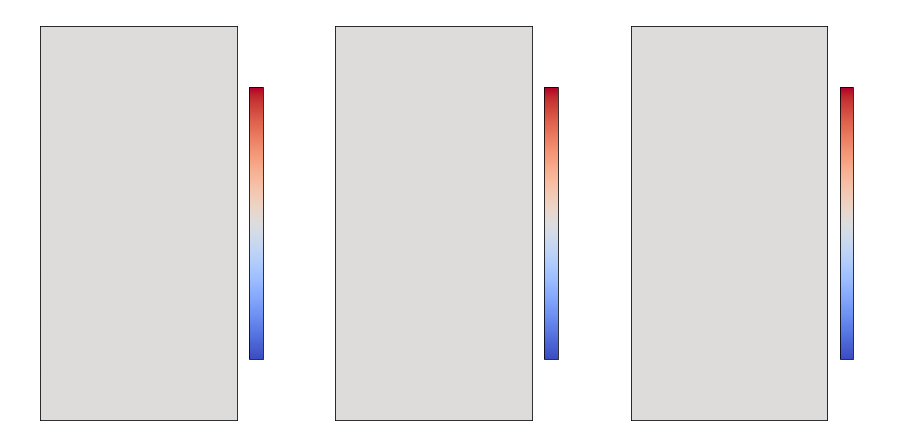

In [67]:
imshow3(ML_state1[-1][0][:,:,:,n] - ML_state2[-1][0][:,:,:,n], eta_vlim=0.01, huv_vlim=1)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

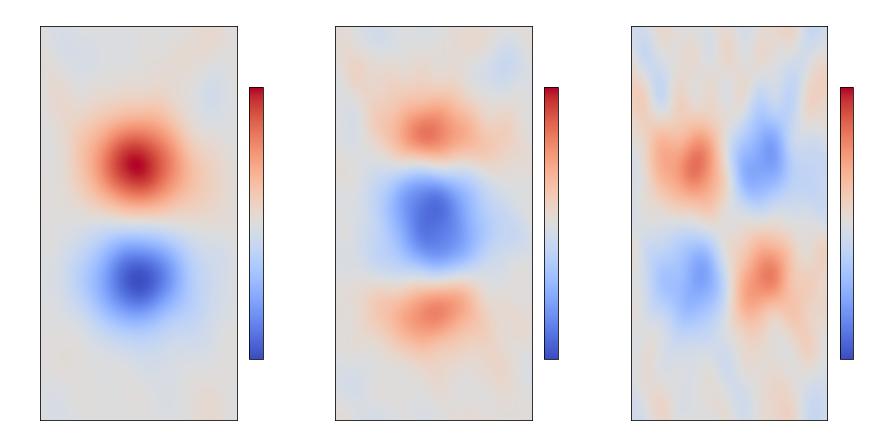

In [68]:
imshow3(ML_state1[-1][0][:,:,:,n])

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

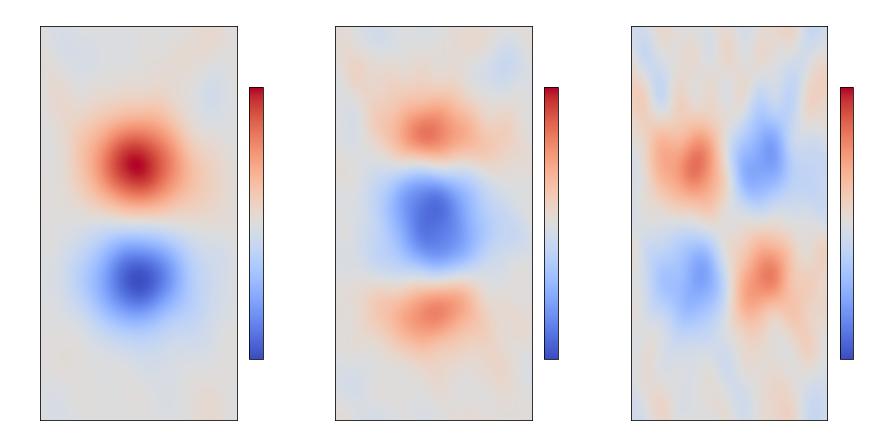

In [69]:
imshow3(ML_state2[-1][0][:,:,:,n])

In [70]:
MLOceanEnsemble0.cleanUp()
MLOceanEnsemble1.cleanUp()
MLOceanEnsemble2.cleanUp()

DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG 

DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG 

DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG DEBUG 

In [71]:
l = 9

In [72]:
lvl_grid_args = initGridSpecs(l)
args =  {
    "nx": lvl_grid_args["nx"],
    "ny": lvl_grid_args["ny"],
    "dx": lvl_grid_args["dx"],
    "dy": lvl_grid_args["dy"],
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

In [73]:
args

{'nx': 512,
 'ny': 1024,
 'dx': 160,
 'dy': 160,
 'gpu_ctx': <gpuocean.utils.Common.CUDAContext at 0x7f8a41216a90>,
 'gpu_stream': <pycuda._driver.Stream at 0x7f8afba40030>,
 'boundary_conditions': <gpuocean.utils.Common.BoundaryConditions at 0x7f8b094e0950>}

In [74]:
data_args = make_init_steady_state(args, a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist)

In [75]:
T, sim_model_error_timestep

(60, 60.0)

In [76]:
Ne = 10
T = 60

In [77]:
#imshow3([data_args['eta'], data_args['hu'], data_args['hv']])
zero_data_args = copy.deepcopy(data_args)
zero_data_args['eta'] = np.zeros_like(data_args['eta'])
zero_data_args['hu'] = np.zeros_like(data_args['eta'])
zero_data_args['hv'] = np.zeros_like(data_args['eta'])

In [78]:
def test_run(xorwow_seed=None, np_seed=None):
    # init_mekl =  ModelErrorKL.ModelErrorKL(**args, **init_model_error_basis_args, xorwow_seed=1, np_seed=1) 
    sim_mekl  =  ModelErrorKL.ModelErrorKL(**args, **sim_model_error_basis_args, xorwow_seed=xorwow_seed, np_seed=np_seed) 

    SL_ensemble = []
    for n in range(Ne):
        sim = make_sim(args, sample_args, init_fields=zero_data_args)
        # init_mekl.perturbSim(sim)
        sim.model_error = sim_mekl
        sim.model_time_step = sim_model_error_timestep

        SL_ensemble.append(sim)

    # for n in range(50):
    #     SL_ensemble[n].dataAssimilationStep(T)

    for n in range(Ne):
        SL_ensemble[n].step(T, apply_stochastic_term=False)
        sim_mekl.perturbSim(SL_ensemble[n], stream=SL_ensemble[n].gpu_stream)
        
        # SL_ensemble[n].perturbState()

    SL_state = np.zeros((3,args["ny"], args["nx"], Ne))
    for n in range(Ne):
        SL_state[:,:,:,n] = SL_ensemble[n].download(interior_domain_only=True)

    return copy.deepcopy(SL_state), SL_ensemble

In [79]:
SL_state, SL_ensemble = test_run()

In [80]:
SL_state0, SL_ensemble0 = test_run(xorwow_seed=1, np_seed=1)

In [81]:
SL_state1, SL_ensemble1 = test_run(xorwow_seed=1, np_seed=1)

In [82]:
for n in range(Ne):
    print(np.max(np.abs(SL_state0-SL_state1)[:,:,:,n], axis=(1,2)))

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

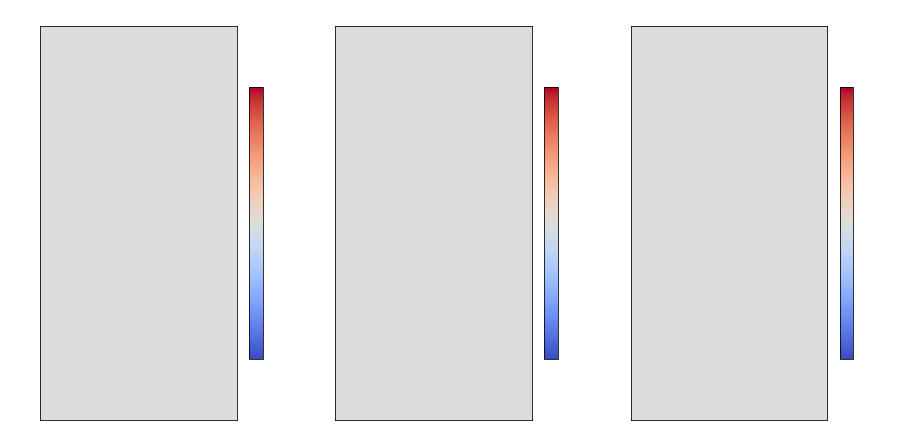

In [83]:
i = 2
imshow3(SL_state0[:,:,:,i] - SL_state1[:,:,:,i], eta_vlim=1e-2, huv_vlim=1)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

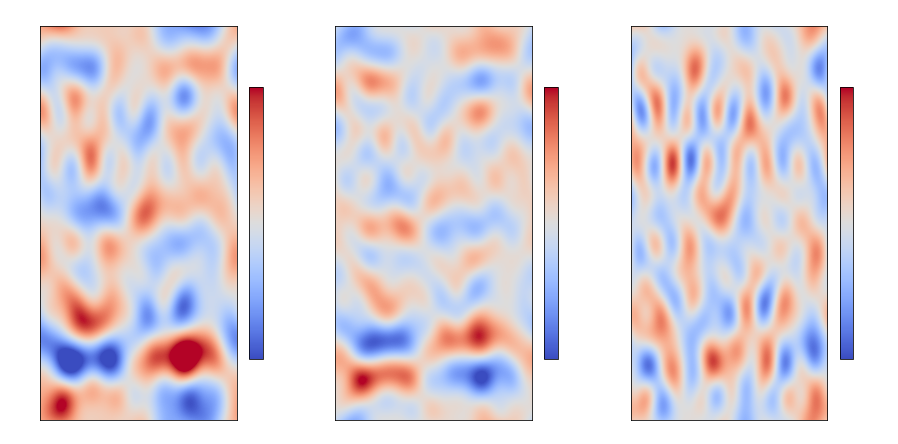

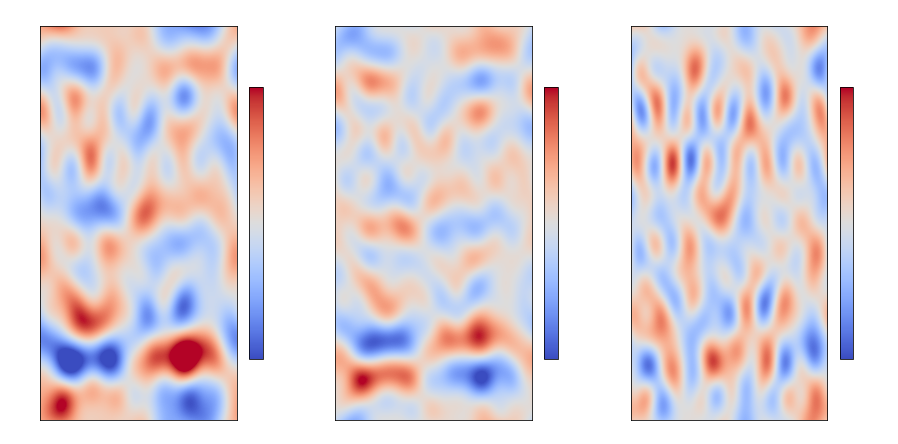

In [84]:
imshow3(SL_state0[:,:,:,i], eta_vlim=1e-2, huv_vlim=1)
imshow3(SL_state1[:,:,:,i], eta_vlim=1e-2, huv_vlim=1)
#imshow3(SL_state1[:,:,:,i+1], eta_vlim=1e-2, huv_vlim=1)

In [85]:
np.mean(np.abs(SL_state-SL_state0), axis=(1,2,3))

array([0.00576403, 0.32667149, 0.35768492])

In [86]:
np.mean(np.abs(SL_state0-SL_state1), axis=(1,2,3))

array([0., 0., 0.])

In [87]:
np.max(np.abs(SL_state0-SL_state1), axis=(1,2,3))

array([0., 0., 0.])

In [88]:
np.all(np.array([sim.dt for sim in SL_ensemble0]) == np.array([sim.dt for sim in SL_ensemble1]) )

True

In [89]:
np.all(np.array([sim.model_time_step for sim in SL_ensemble0]) == np.array([sim.model_time_step for sim in SL_ensemble1]) )

True